In [1]:
import os, sys, getpass

sys.path.append(r"C:\Users\gizem\Desktop\master_thesis\source")

import glob
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
#from scripts.run_inference_mp import *
import math
from math import gamma

In [2]:
def visualize_llh(dict_L, n_train, path_to_save):
    for m, df_L in dict_L.items():
        df_L_norm = df_L.cumsum().div((df_L.index + 1), axis=0)
        plt.figure()
        df_L_norm.head(n_train).plot()
        plt.xlabel('Number of trajectories')
        plt.ylabel('Train log-likelihood')
        plt.savefig(os.path.join(path_to_save, f'llh_{m}.png'))
        plt.close()

In [3]:
def get_time_of_stay_in_state(df_traj, node, df_all=None):
    states = [0, 1]
    df = df_traj.copy()
    df.loc[:, 'block'] = (df[node].shift(1) != df[node]).astype(int).cumsum()
    # last_block = df.block.max()
    # tmp = df[df.block<last_block].reset_index().groupby([node, 'block'])['index'].apply(np.array)
    tmp = df.reset_index().groupby([node, 'block'])['index'].apply(np.array)
    T = np.zeros(len(states))
    for val in states:
        if val in tmp.index:
            for arr in tmp.loc[val].values:
                start = arr[0]
                end = arr[-1] + 1 if arr[-1] != df.index.values[-1] else arr[-1]
    return T


def get_number_of_transitions(df_traj, node):
    change0to1 = (df_traj[node].diff() == 1)
    change1to0 = (df_traj[node].diff() == -1)
    M0 = change0to1.sum()  # also M0
    M1 = change1to0.sum()  # also M1
    return np.array([M0, M1])

In [4]:
def marginalized_llh_homogenous_mp(df_traj, params, node):
    n_states = df_traj[node].nunique()
    marg_llh = 0

    alpha_list = params[node]['alpha']
    beta_list = params[node]['beta']
    T = get_time_of_stay_in_state(df_traj, node=node)
    M = get_number_of_transitions(df_traj, node=node)
    for i in range(n_states):
        p = beta_list[i] * ((T[i] + beta_list[i]) ** (-M[i] - alpha_list[i])) * gamma(M[i] + alpha_list[i]) / gamma(
            alpha_list[i])
        marg_llh += np.log(p)
    return marg_llh

In [5]:
def divisors(n):
    divs = [1]
    for i in range(2, int(math.sqrt(n)) + 1):
        if n % i == 0:
            divs.extend([i, n / i])
    return np.sort(list(set(divs))).astype(int)

In [6]:
params = {r"$X_{1}$": {"alpha": [5,10],
                       "beta": [5,20]},
          r"$X_{2}$": {"alpha": [10, 10],
                       "beta": [10, 5]}}

In [7]:
params

{'$X_{1}$': {'alpha': [5, 10], 'beta': [5, 20]},
 '$X_{2}$': {'alpha': [10, 10], 'beta': [10, 5]}}

In [8]:
main_path = r"C:\Users\gizem\Desktop\DATA\roc_analysis"
folder = r"\1592251084_5sec_200train_0test_3model_detFunctionPolicy_['particleFilter']_seed0_"
# folder = r"\1592868242_5sec_200train_0test_3model_detFunctionPolicy_['particleFilter']_seed0_"
path_0 = main_path + folder + r"\psi_0"
path_1 = main_path + folder + r"\psi_1"
path_2 = main_path + folder + r"\psi_2"

In [9]:
L_list =[]

for p in [path_0, path_1, path_2]:
    df_data = pd.read_csv(p + r"\dataset.csv", index_col=0)
    df_l = pd.read_csv(p + r"\llh_particleFilter.csv", index_col=0)
    traj_id_list = df_data.traj_id.unique()
    for traj_id in traj_id_list:
        df_traj = df_data[df_data.traj_id==traj_id]
        ml_1 = marginalized_llh_homogenous_mp(df_traj, params, node = '$X_{1}$')
        ml_2 = marginalized_llh_homogenous_mp(df_traj, params, node = '$X_{2}$')
        df_l.loc[traj_id-1] = df_l.loc[traj_id-1] + ml_1 + ml_2
    df_l = df_l.append(df_l)
    df_l.reset_index(drop=True, inplace=True)
    L_list += [df_l]

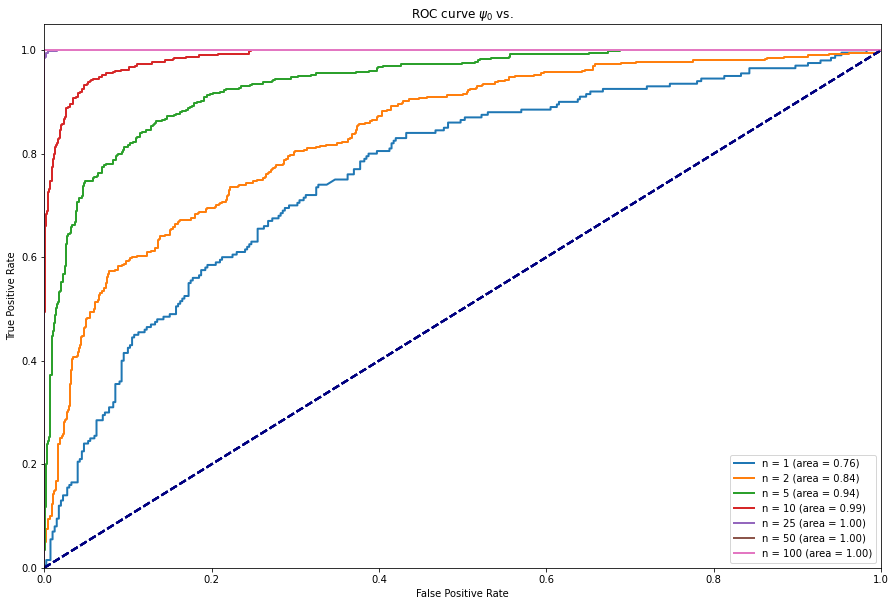

In [10]:
n_classes = 3
n_sample_per_class = 200
# L_list = [llh_0, llh_1, llh_2]
plt.figure(figsize=(15,10))
for n in divisors(n_sample_per_class):
    df_scores = pd.DataFrame()
    y_labels = None

    for i, df_loglh in enumerate(L_list):
        # Concatenate likelihoods from different datasets
        df_lh = np.exp(df_loglh)
        df_lh = df_lh.divide(df_lh.values.sum(axis=1), axis=0)
        for k in range(n):
            df_shuffled_ = df_lh.sample(frac=1).reset_index(drop=True)
            df_scores = df_scores.append(df_shuffled_.groupby(df_shuffled_.index // n).mean())

        # Create and concatenate labels for different classes
        n_class_samples = int(len(df_loglh))
        y_class_labels = np.zeros((n_class_samples, n_classes))
        y_class_labels[:, i] = 1
        if y_labels is None:
            y_labels = y_class_labels
        else:
            y_labels = np.concatenate((y_labels, y_class_labels))

    df_scores.reset_index(drop=True, inplace=True)

    n_all_samples = len(df_scores)
    y_scores = df_scores.values  # Normalizing likelihoods

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for m in range(n_classes):
        fpr[m], tpr[m], _ = roc_curve(y_labels[:, m], y_scores[:, m])
        roc_auc[m] = auc(fpr[m], tpr[m])

    
    if n in [1,2,5,10,25,50,100]:
        c = 0
        plt.plot(fpr[c], tpr[c],# color='darkorange',
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(r'ROC curve $\psi_{0}$ vs. ') # + f'all (n={n})')
        plt.legend(loc="lower right")
        # plt.savefig(r"C:\Users\gizem\Desktop\DATA\roc_analysis\1592350512_5sec_200train_0test_3model_detFunctionPolicy_['exactUpdate', 'particleFilter']_seed0_\all_exact.png")
        # plt.show()


In [ ]:
visualize_llh({'particleFilter':llh_2}, 200, path_to_save=main_path+folder)